In [1]:
import jVMC
import jax
#from jax.config import config
jax.config.update("jax_enable_x64", True)
import jax.random as jrnd
import jax.random as random

import jax.numpy as jnp
from functools import partial
import numpy as np
import jVMC.global_defs as global_defs
from tqdm import tqdm
import matplotlib.pyplot as plt
from flax import linen as nn
from typing import Any, List, Optional, Tuple
from jax import Array, vmap, jit
import math 
import optax
def adam_update(psi,psiSampler,H,stateAdam,optAdam):
    psi_s, psi_logPsi, psi_p = psiSampler.sample()

    Eloc = H.get_O_loc(psi_s, psi, psi_logPsi)
    Eso = jVMC.util.SampledObs(Eloc, psi_p)
    Emean = Eso.mean()[0]
    Evar = Eso.var()[0]
    Opsi = psi.gradients(psi_s)
    grads = jVMC.util.SampledObs(Opsi, psi_p)
    Egrad = 2.*grads.covar(Eso)
    grad = jnp.real(Egrad)
    
    psi_params = psi.get_parameters()
    
    upAdam, stateAdam = optAdam.update(
        grad.reshape(psi_params.shape), stateAdam, psi_params  # type: ignore
    )
    
    params = optax.apply_updates(psi_params, upAdam)  # type: ignore
    
    psi.set_parameters(params)
    return Emean.real,Evar,stateAdam


In [2]:
@jax.jit
def sorting_gumble(sample,logits,gumbel,states):
    indexes = jnp.argsort((-gumbel),axis=None)#.reshape(shape_gumbel)
    numSamples = sample.shape[0]
    ldim = sample.shape[1]
    L = sample.shape[2]
    #jax.debug.print("shape {x},{y},{z}",x=numSamples,y=ldim,z=L)
    indexes_states = (indexes // ldim)[:numSamples]
    sample = sample.reshape(-1,L)[indexes]
    sample = sample.reshape(ldim,numSamples,L)
    sample = jnp.swapaxes(sample,0,1)
    
    logits = logits.ravel()[indexes]
    logits = logits.reshape(ldim,numSamples).T
    
    gumbel = gumbel.ravel()[indexes]
    gumbel = gumbel.reshape(ldim,numSamples).T

    vals, treedef  = jax.tree_util.tree_flatten(states)
    vals_ordered = [v[indexes_states] for v in vals]
    states = jax.tree_util.tree_unflatten(treedef,vals_ordered)
    return sample,logits,gumbel,states

class gumbel_wrapper(nn.Module):
    """
    Wrapper module for symmetrization.
    This is a wrapper module for the incorporation of lattice symmetries. 
    The given plain ansatz :math:`\\psi_\\theta` is symmetrized as

        :math:`\\Psi_\\theta(s)=\\frac{1}{|\\mathcal S|}\\sum_{\\tau\\in\\mathcal S}\\psi_\\theta(\\tau(s))`

    where :math:`\\mathcal S` denotes the set of symmetry operations (``orbit`` in our nomenclature).

    Initialization arguments:
        * ``orbit``: orbits which define the symmetry operations (instance of ``util.symmetries.LatticeSymmetry``)
        * ``net``: Flax module defining the plain ansatz.
        * ``avgFun``: Different choices for the details of averaging.

    """
    #orbit: LatticeSymmetry
    net: callable
    is_gumbel = True

    #avgFun: callable = avgFun_Coefficients_Exp
    def __setup__(self):
        self.L = self.net.L

    def __post_init__(self):

        super().__post_init__()
        #self.orbit = None
        #self.is_generator = self.net.is_generator
    """
    def __call__(self, x):

        inShape = x.shape
        x = 2 * x - 1
        x = jax.vmap(lambda o, s: jnp.dot(o, s.ravel()).reshape(inShape), in_axes=(0, None))(self.orbit.orbit, x)
        x = (x + 1) // 2

        def evaluate(x):
            return self.net(x)

        res = jax.vmap(evaluate)(x)
        return self.avgFun(res, self.orbit.factor)
    """
    
    def __call__(self,*args,**kwargs):
        
        #def evaluate(x):
        #    return self.net(x)

        #res = jax.vmap(evaluate)(x)
        return self.net(*args,**kwargs)
        
    def _apply_fun(self, *args,**kwargs):
        return self.net.apply(*args,**kwargs)

# ** end class SymNet
        #return sample,logits,gumbel,states
    
    
    def _gumbel_step(self,sample,logits,gumbel,key,states,position):        
        particles_left = self.net.Q - jnp.sum(sample[0]+jnp.abs(sample[0]))//2
        #new samples with (0,..,ldim-1) at position
        sample = jnp.array([sample[0].at[position].set(l) for l in jnp.arange(self.net.ldim)])
        #right shifted input
        inputt = jnp.array([jnp.pad(sample[0,:-1],(1,0))])
        logitnew, next_states = self(inputt[:,position],block_states = states, output_state=True)
        #logitnew, next_states = self.net.net(inputt[:,position],block_states = states, output_state=True)
    
        #jax.debug.print("pl: {x}",x=particles_left)
        must_give = jax.nn.relu(particles_left-self.net.max_particles[position])

        # number of particles that can be assigned
        can_give = jnp.minimum(particles_left, self.net.ldim-1)
        mask = (self.net.must_mask[must_give] + 
                    self.net.can_mask[can_give.astype(int)]) 
        #logit_renorm =  logitnew - mask ** jnp.inf
        #jax.debug.print("mask {x}", x=mask)
        logitnew =  jax.nn.log_softmax(logitnew - mask ** jnp.inf)
        #jax.debug.print("logits new {x}", x=logitnew)
        #jax.debug.print("logits[0] {x}", x=logits[0])
        
        logitnew = logits[0] + logitnew - mask ** jnp.inf
        #jax.debug.print("logits new {x}", x=logitnew)

        gumbelnew = logitnew + jrnd.gumbel(key[0],shape=(self.net.ldim,))  ## logitnew or logits[0]?
        #gumbelnew = logits[0] + jrnd.gumbel(key[0],shape=(ldim,))
        #jax.debug.print("gumbelnew new {x}", x=gumbelnew)

        Z = jnp.nanmax(gumbelnew)
        gumbelnew = jnp.nan_to_num(-jnp.log(
            jnp.exp(-gumbel[0])-jnp.exp(-Z)+jnp.exp(-gumbelnew) # -sign at gumbelnew??
            ),nan=-jnp.inf)
        #gumbelnew = (-jnp.log(jnp.exp(-gumbel[0])-jnp.exp(-Z)+jnp.exp(gumbelnew)))
        gumbelnew = gumbelnew- mask ** jnp.inf
        return sample, logitnew, gumbelnew, next_states
    def sample(self, numSamples: int, key) -> Array:
        """Autoregressively sample a spin configuration.

        Args:
            * ``numSamples``: The number of configurations to generate.
            * ``key``: JAX random key.

        Returns:
            A batch of spin configurations.
        """
        
        """
        def generate_sample(key):
            key = jrnd.split(key, self.net.L)
            logits, carry = self(jnp.zeros(1,dtype=int),block_states = None, output_state=True)

            choice = jrnd.categorical(key[0], logits.ravel()) # abide by the indexing convention and apply -1
            s_cumsum = self.net.Q - choice # create cumsum of the quantum number
            _, s = self._scanning_fn((jnp.expand_dims(choice,0),carry,s_cumsum),(key[1:],jnp.arange(1,self.net.L)))
            return jnp.concatenate([jnp.expand_dims(choice,0),s])
        """
        # get the samples
        keys = jrnd.split(key, (self.net.L))
        ## init stap
        shape_samples = (numSamples,self.net.ldim,self.net.L)
        shape_logits = (numSamples,self.net.ldim)
        shape_gumbel = (numSamples,self.net.ldim)
        #print(shape_samples,shape_logits)
        working_space_samples = jnp.full(shape_samples,-2,dtype=jnp.int64)
        working_space_logits = jnp.full(shape_logits,-jnp.inf,dtype=jnp.float64)
        working_space_gumbel = jnp.full(shape_gumbel,-jnp.inf,dtype=jnp.float64)
        
        working_space_samples = working_space_samples.at[0,0,0].set(0)
        working_space_logits = working_space_logits.at[0,0].set(0.)
        working_space_gumbel = working_space_gumbel.at[0,0].set(0.)
        
        states = None
        init_work = partial(self._gumbel_step, position=0,states=states)
        key0 = jrnd.split(keys[0],numSamples)
        key0 = jnp.expand_dims(key0,-2)
        sample,logits,gumbel,states  = jax.vmap(init_work)(working_space_samples,working_space_logits,working_space_gumbel,key0)
        
        init_carry = sorting_gumble(sample,logits,gumbel,states)
        
        res,_ = self._scanning_fn(init_carry,(keys[1:],jnp.arange(1,self.net.L)))
        samples, logits,gumbels,_ = res
        
        kappa = gumbels[0,1]
        #jax.debug.print("kappa {x}", x=kappa)
        #if not self.orbit is None:
        #    logits = self(samples)
            

        re_weights = jnp.nan_to_num(jnp.exp(logits[:,0]) /(-jnp.expm1(-jnp.exp(logits[:,0]-kappa))),0)
        #jax.debug.print("re {x}", x=re_weights)

            
        # return to the spinless representation
        return samples[:,0,:],logits[:,0]*self.net.logProbFactor,re_weights/jnp.sum(re_weights)

    @partial(nn.scan,
             variable_broadcast='params',
             split_rngs={'params': False})
    def _scanning_fn(self, carry, key):
        position = key[1]
        sample = carry[0]
        #jax.debug.print("{x}", x=sample)

        logits = carry[1]
        gumbel = carry[2]
        states = carry[3]
        keys = jrnd.split(key[0],carry[0].shape[0])
        keys = jnp.expand_dims(keys,-2)

        p_workN = partial(self._gumbel_step,position=position)
        sample,logits,gumbel,states = jax.vmap(p_workN)(sample,logits,gumbel,keys,states)
        #jax.debug.print("gumbelnew new {x}", x=gumbel)

        #### sorting gumble value
        return sorting_gumble(sample,logits,gumbel,states),None
        """
        logits, next_states = self(carry[0],block_states = carry[1], output_state=True)
        #jax.debug.print("logits {x}\n carry {y}",x=logits,y=carry)

        ##############################################
        # mask logits
        # number of particles that mus assigned
        must_give = nn.relu(carry[2]-self.net.max_particles[key[1]])
        # number of particles that can be assigned
        can_give = jnp.minimum(carry[2], self.net.LocalHilDim-1)
        # compute mask
        mask = (self.net.must_mask[must_give] + 
                    self.net.can_mask[can_give.astype(int)]) 
        ##############################################
        logits = logits - mask ** jnp.inf
        choice = jrnd.categorical(key[0], logits.ravel().real) # abide by the indexing convention
        ##############################################
        s_cumsum = carry[2] - choice
        return (jnp.expand_dims(choice,0), next_states, s_cumsum), choice
        """

class gumbel_wrapper_no(nn.Module):
    """
    Wrapper module for symmetrization.
    This is a wrapper module for the incorporation of lattice symmetries. 
    The given plain ansatz :math:`\\psi_\\theta` is symmetrized as

        :math:`\\Psi_\\theta(s)=\\frac{1}{|\\mathcal S|}\\sum_{\\tau\\in\\mathcal S}\\psi_\\theta(\\tau(s))`

    where :math:`\\mathcal S` denotes the set of symmetry operations (``orbit`` in our nomenclature).

    Initialization arguments:
        * ``orbit``: orbits which define the symmetry operations (instance of ``util.symmetries.LatticeSymmetry``)
        * ``net``: Flax module defining the plain ansatz.
        * ``avgFun``: Different choices for the details of averaging.

    """
    #orbit: LatticeSymmetry
    net: callable
    is_gumbel = True

    #avgFun: callable = avgFun_Coefficients_Exp
    def __setup__(self):
        self.L = self.net.L

    def __post_init__(self):

        super().__post_init__()
        #self.orbit = None
        #self.is_generator = self.net.is_generator
    """
    def __call__(self, x):

        inShape = x.shape
        x = 2 * x - 1
        x = jax.vmap(lambda o, s: jnp.dot(o, s.ravel()).reshape(inShape), in_axes=(0, None))(self.orbit.orbit, x)
        x = (x + 1) // 2

        def evaluate(x):
            return self.net(x)

        res = jax.vmap(evaluate)(x)
        return self.avgFun(res, self.orbit.factor)
    """
    
    def __call__(self,*args,**kwargs):
        
        #def evaluate(x):
        #    return self.net(x)

        #res = jax.vmap(evaluate)(x)
        return self.net(*args,**kwargs)
        
    def _apply_fun(self, *args,**kwargs):
        return self.net.apply(*args,**kwargs)

# ** end class SymNet
        #return sample,logits,gumbel,states
    
    
    def _gumbel_step(self,sample,logits,gumbel,key,states,position):        
        #new samples with (0,..,ldim-1) at position
        sample = jnp.array([sample[0].at[position].set(l) for l in jnp.arange(self.net.ldim)])
        #right shifted input
        inputt = jnp.array([jnp.pad(sample[0,:-1],(1,0))])
        logitnew, next_states = self(inputt[:,position],block_states = states, output_state=True)
        #logitnew, next_states = self.net.net(inputt[:,position],block_states = states, output_state=True)
    
        #jax.debug.print("pl: {x}",x=particles_left)
        #must_give = jax.nn.relu(particles_left-self.net.max_particles[position])

        # number of particles that can be assigned
        #can_give = jnp.minimum(particles_left, self.net.ldim-1)
        #mask = (self.net.must_mask[must_give] + 
        #            self.net.can_mask[can_give.astype(int)]) 
        #logit_renorm =  logitnew - mask ** jnp.inf
        #jax.debug.print("mask {x}", x=mask)
        #logitnew =  jax.nn.log_softmax(logitnew - mask ** jnp.inf)
        #jax.debug.print("logits new {x}", x=logitnew)
        #jax.debug.print("logits[0] {x}", x=logits[0])
        
        logitnew = logits[0] + logitnew #- mask ** jnp.inf
        #jax.debug.print("logits new {x}", x=logitnew)

        gumbelnew = logitnew + jrnd.gumbel(key[0],shape=(self.net.ldim,))  ## logitnew or logits[0]?
        #gumbelnew = logits[0] + jrnd.gumbel(key[0],shape=(ldim,))
        #jax.debug.print("gumbelnew new {x}", x=gumbelnew)

        Z = jnp.nanmax(gumbelnew)
        gumbelnew = jnp.nan_to_num(-jnp.log(
            jnp.exp(-gumbel[0])-jnp.exp(-Z)+jnp.exp(-gumbelnew) # -sign at gumbelnew??
            ),nan=-jnp.inf)
        #gumbelnew = (-jnp.log(jnp.exp(-gumbel[0])-jnp.exp(-Z)+jnp.exp(gumbelnew)))
        gumbelnew = gumbelnew#- mask ** jnp.inf
        return sample, logitnew, gumbelnew, next_states
    def sample(self, numSamples: int, key) -> Array:
        """Autoregressively sample a spin configuration.

        Args:
            * ``numSamples``: The number of configurations to generate.
            * ``key``: JAX random key.

        Returns:
            A batch of spin configurations.
        """
        
        """
        def generate_sample(key):
            key = jrnd.split(key, self.net.L)
            logits, carry = self(jnp.zeros(1,dtype=int),block_states = None, output_state=True)

            choice = jrnd.categorical(key[0], logits.ravel()) # abide by the indexing convention and apply -1
            s_cumsum = self.net.Q - choice # create cumsum of the quantum number
            _, s = self._scanning_fn((jnp.expand_dims(choice,0),carry,s_cumsum),(key[1:],jnp.arange(1,self.net.L)))
            return jnp.concatenate([jnp.expand_dims(choice,0),s])
        """
        # get the samples
        keys = jrnd.split(key, (self.net.L))
        ## init stap
        shape_samples = (numSamples,self.net.ldim,self.net.L)
        shape_logits = (numSamples,self.net.ldim)
        shape_gumbel = (numSamples,self.net.ldim)
        #print(shape_samples,shape_logits)
        working_space_samples = jnp.full(shape_samples,-2,dtype=jnp.int64)
        working_space_logits = jnp.full(shape_logits,-jnp.inf,dtype=jnp.float64)
        working_space_gumbel = jnp.full(shape_gumbel,-jnp.inf,dtype=jnp.float64)
        
        working_space_samples = working_space_samples.at[0,0,0].set(0)
        working_space_logits = working_space_logits.at[0,0].set(0.)
        working_space_gumbel = working_space_gumbel.at[0,0].set(0.)
        
        states = None
        init_work = partial(self._gumbel_step, position=0,states=states)
        key0 = jrnd.split(keys[0],numSamples)
        key0 = jnp.expand_dims(key0,-2)
        sample,logits,gumbel,states  = jax.vmap(init_work)(working_space_samples,working_space_logits,working_space_gumbel,key0)
        
        init_carry = sorting_gumble(sample,logits,gumbel,states)
        
        res,_ = self._scanning_fn(init_carry,(keys[1:],jnp.arange(1,self.net.L)))
        samples, logits,gumbels,_ = res
        
        kappa = gumbels[0,1]
        #jax.debug.print("kappa {x}", x=kappa)
        #if not self.orbit is None:
        #    logits = self(samples)
            

        re_weights = jnp.nan_to_num(jnp.exp(logits[:,0]) /(-jnp.expm1(-jnp.exp(logits[:,0]-kappa))),0)
        #jax.debug.print("re {x}", x=re_weights)

            
        # return to the spinless representation
        return samples[:,0,:],logits[:,0]*self.net.logProbFactor,re_weights/jnp.sum(re_weights)

    @partial(nn.scan,
             variable_broadcast='params',
             split_rngs={'params': False})
    def _scanning_fn(self, carry, key):
        position = key[1]
        sample = carry[0]
        #jax.debug.print("{x}", x=sample)

        logits = carry[1]
        gumbel = carry[2]
        states = carry[3]
        keys = jrnd.split(key[0],carry[0].shape[0])
        keys = jnp.expand_dims(keys,-2)

        p_workN = partial(self._gumbel_step,position=position)
        sample,logits,gumbel,states = jax.vmap(p_workN)(sample,logits,gumbel,keys,states)
        #jax.debug.print("gumbelnew new {x}", x=gumbel)

        #### sorting gumble value
        return sorting_gumble(sample,logits,gumbel,states),None
        """
        logits, next_states = self(carry[0],block_states = carry[1], output_state=True)
        #jax.debug.print("logits {x}\n carry {y}",x=logits,y=carry)

        ##############################################
        # mask logits
        # number of particles that mus assigned
        must_give = nn.relu(carry[2]-self.net.max_particles[key[1]])
        # number of particles that can be assigned
        can_give = jnp.minimum(carry[2], self.net.LocalHilDim-1)
        # compute mask
        mask = (self.net.must_mask[must_give] + 
                    self.net.can_mask[can_give.astype(int)]) 
        ##############################################
        logits = logits - mask ** jnp.inf
        choice = jrnd.categorical(key[0], logits.ravel().real) # abide by the indexing convention
        ##############################################
        s_cumsum = carry[2] - choice
        return (jnp.expand_dims(choice,0), next_states, s_cumsum), choice
        """

In [3]:
L = 20
T = 0.01
E_c = 0.40
E_J = np.array([12.500,12.00]*(L//2) + ([12.500] if ((L%2)==1) else [] ))
lDim = 7

#transmon on a chain
hamiltonian1D = jVMC.operator.BranchFreeOperator(lDim=lDim)
for l in range(L):    
    hamiltonian1D.add(jVMC.operator.scal_opstr(-E_J[l]/2., (jVMC.operator.E(l,lDim),)))
    hamiltonian1D.add(jVMC.operator.scal_opstr(-E_J[l]/2., (jVMC.operator.Ed(l,lDim),)))
    #hamiltonian1D.add(jVMC.operator.scal_opstr(-E_J[l], (jVMC.operator.create(l,lDim),jVMC.operator.Id(l,lDim))))
    #hamiltonian1D.add(jVMC.operator.scal_opstr(-E_J[l], (jVMC.operator.destroy(l,lDim),jVMC.operator.Id(l,lDim))))
    
    hamiltonian1D.add(jVMC.operator.scal_opstr(4*E_c, (jVMC.operator.number(l,lDim ),jVMC.operator.number(l,lDim )) ))
    if (l<(L-1)):
        hamiltonian1D.add(jVMC.operator.scal_opstr(T, (jVMC.operator.number(l,lDim ),jVMC.operator.number(l+1,lDim )) ))
hamiltonian1D.compile();

H = hamiltonian1D


In [32]:
depth_RWKV = 5
emb_RWKV =16
hidden_size=32
num_heads = 4
#net_RWKV = jVMC.nets.bosons.RWKV(L,Q=None,M=None,LocalHilDim=lDim,num_layers=depth_RWKV,embedding_size=emb_RWKV)

net_RWKV = jVMC.nets.RWKV.RpxRWKV(L,LocalHilDim=lDim,hidden_size=hidden_size,num_heads=num_heads,embedding_size=emb_RWKV,num_layers=depth_RWKV,bias=True)
net_RWKV_gumbel = jVMC.nets.RWKV.RpxRWKV(L,LocalHilDim=lDim,hidden_size=hidden_size,num_heads=num_heads,embedding_size=emb_RWKV,num_layers=depth_RWKV,bias=True)




In [33]:
homFock = jnp.array([[[1]*L]])

In [34]:
#net_RWKV = jVMC.nets.bosons.GPT(L,N,ldim,emb_RWKV,depth_RWKV,1)
gumbel_net = gumbel_wrapper_no(net_RWKV_gumbel)


In [35]:
seed = 252
psi_RWKV = jVMC.vqs.NQS(net_RWKV,seed=seed)
#psi_RWKV = jVMC.vqs.NQS(symNet)

psi_RWKV_gumbel = jVMC.vqs.NQS(gumbel_net,seed=seed)
#psi_RWKV_gumbel = jVMC.vqs.NQS(symNet_gumble)

psi_RWKV(homFock),psi_RWKV_gumbel(homFock)

(Array([[-6.22427426]], dtype=float64), Array([[-5.91539179]], dtype=float64))

In [36]:
psi_RWKV.is_generator

True

In [37]:
psi_RWKV_gumbel.is_gumbel,psi_RWKV.is_gumbel,psi_RWKV_gumbel.is_generator



(True, False, True)

In [38]:
key = jrnd.PRNGKey(1)
key2 = jrnd.PRNGKey(1)

sampler = jVMC.sampler.MCSampler(psi_RWKV,(L,),key)
sampler_gumbel = jVMC.sampler.MCSampler(psi_RWKV_gumbel,(L,),key2)

lr_SR = 1e-2
minSR_equation = jVMC.util.MinSR(sampler, makeReal='real',diagonalShift=1e-3,diagonalMulti=1e-3)
minSR_equation_gumbel = jVMC.util.MinSR(sampler_gumbel, makeReal='real',diagonalShift=1e-3,diagonalMulti=1e-3)
#minSR_equation = jVMC.util.TDVP(sampler,rhsPrefactor=1.,diagonalShift=1.1, makeReal='real')#,diagonalShift=1e-2)#,diagonalMulti=1e-3)
#minSR_equation_gumbel = jVMC.util.TDVP(sampler_gumbel,rhsPrefactor=1.,diagonalShift=1.1, makeReal='real')#,diagonalShift=1e-2)#,diagonalMulti=1e-3)
#tdvpEquation = jVMC.util.tdvp.TDVP(sampler, rhsPrefactor=1.,
#                                   pinvTol=1e-8, diagonalShift=10, makeReal='real')

stepperSR = jVMC.util.stepper.Euler(timeStep=lr_SR)  
    

In [39]:
#%timeit sampler_gumbel.sample(numSamples=2**6)
#%timeit sampler.sample(numSamples=2**6)
#sampler_gumbel.sample(numSamples=2**6)
sampler.sample(numSamples=2**6)


(Array([[[5, 5, 3, 1, 3, 1, 3],
         [4, 0, 4, 0, 6, 5, 4],
         [2, 3, 0, 4, 4, 3, 1],
         [4, 4, 0, 1, 2, 2, 4],
         [4, 5, 0, 5, 5, 4, 1],
         [2, 0, 2, 0, 0, 4, 4],
         [6, 0, 4, 3, 4, 0, 4],
         [2, 1, 3, 4, 4, 2, 6],
         [6, 3, 6, 0, 2, 1, 3],
         [1, 0, 0, 1, 1, 1, 5],
         [4, 3, 1, 4, 4, 4, 0],
         [0, 4, 0, 4, 2, 0, 2],
         [0, 6, 4, 1, 6, 3, 1],
         [2, 6, 2, 1, 1, 3, 5],
         [4, 6, 4, 6, 0, 6, 5],
         [2, 0, 4, 1, 0, 1, 0],
         [6, 1, 6, 0, 1, 4, 4],
         [6, 3, 1, 3, 3, 5, 5],
         [2, 4, 5, 0, 2, 1, 4],
         [4, 3, 4, 0, 0, 2, 0],
         [4, 0, 4, 2, 0, 6, 6],
         [5, 4, 4, 3, 4, 1, 0],
         [5, 3, 0, 5, 6, 4, 1],
         [0, 4, 4, 0, 6, 6, 6],
         [2, 4, 3, 3, 4, 4, 4],
         [4, 3, 1, 2, 0, 4, 5],
         [2, 6, 4, 0, 6, 6, 4],
         [6, 5, 0, 1, 3, 0, 3],
         [4, 1, 2, 1, 3, 3, 3],
         [6, 3, 1, 5, 4, 1, 3],
         [6, 4, 4, 4, 4, 4, 2],
        

In [40]:
training_steps= 200
resTraining = np.zeros((training_steps,2))
resTraining_gumbel = np.zeros((training_steps,2))

numS = 2**10
pbar = tqdm(range(training_steps),ncols=250)
for n,p in enumerate(pbar):
    
    dpOld = psi_RWKV.get_parameters()        
    
    #print(dpOld)
    dp, _ = stepperSR.step(0, minSR_equation, dpOld, hamiltonian=H, psi=psi_RWKV, numSamples=numS)
    psi_RWKV.set_parameters(jnp.real(dp))
    resTraining[n] = [jnp.real(minSR_equation.ElocMean0) , minSR_equation.ElocVar0 ]
    #print(dp)
    
    dpOld = psi_RWKV_gumbel.get_parameters()                
    #print(dpOld)
    dp, _ = stepperSR.step(0, minSR_equation_gumbel, dpOld, hamiltonian=H, psi=psi_RWKV_gumbel, numSamples=numS)
    #print(dp)
    psi_RWKV_gumbel.set_parameters(jnp.real(dp))
    resTraining_gumbel[n] = [jnp.real(minSR_equation_gumbel.ElocMean0) , minSR_equation_gumbel.ElocVar0 ]
    
    pbar.set_description(f"energy: {resTraining[n][0]:.4f}+-{np.sqrt(resTraining[n][1]):.4f} __ gumbel "+f"energy: {resTraining_gumbel[n][0]:.4f}+-{np.sqrt(resTraining_gumbel[n][1]):.2f}")
    pbar.update(1)


energy: -49.1729+-0.1411 __ gumbel energy: -49.1735+-0.11:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 175/200 [18:28<02:20,  5.60s/it]Exception ignored in: <generator object tqdm.__iter__ at 0x7f38f8484510>
Traceback (most recent call last):
  File "/Data/pgi-8/steinhuber/software/miniconda3/envs/jvmc/lib/python3.9/site-packages/tqdm/std.py", line 1183, in __iter__
    yield obj
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f4a69f5ccd0>>
Traceback (most recent call last):
  File "/Data/pgi-8/steinhuber/software/miniconda3/envs/jvmc/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

Text(0.5, 0.98, 'training SR, L 7, lDim 7, T 0.010, Ec 0.40,\n EJ [12.5 12.  12.5 12.  12.5 12.  12.5]')

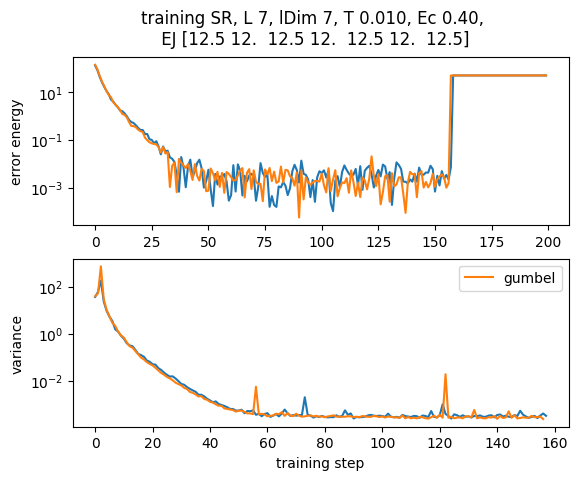

In [41]:

fig,ax = plt.subplots(2)
ax[0].semilogy(np.abs(resTraining[:,0]-(-49.17507554699696)))
ax[1].semilogy(resTraining[:,1]/jnp.abs(resTraining[:,0]))
ax[0].semilogy(np.abs(resTraining_gumbel[:,0]-(-49.17507554699696)),label="gumbel")
ax[1].semilogy(resTraining_gumbel[:,1]/jnp.abs(resTraining_gumbel[:,0]),label="gumbel")
ax[1].legend()
ax[0].set_ylabel("error energy")
ax[1].set_ylabel("variance")
ax[1].set_xlabel("training step")
fig.suptitle(f"training SR, L {L}, lDim {lDim}, T {T:.3f}, Ec {E_c:.2f},\n EJ {E_J}")


In [28]:
#adam 
lr_ADAM = 1e-3
optAdam = optax.inject_hyperparams(optax.adamax)(learning_rate=lr_ADAM)

stateAdam = optAdam.init(psi_RWKV.get_parameters()) 
stateAdamGumbel = optAdam.init(psi_RWKV_gumbel.get_parameters()) 

training_steps= 500
resTrainingADAM = np.zeros((training_steps,2))
resTrainingADAM_gumbel = np.zeros((training_steps,2))

numS = 2**10
sampler.set_number_of_samples(numS)
sampler_gumbel.set_number_of_samples(numS)

pbar = tqdm(range(training_steps))
for n,p in enumerate(pbar):
    
    Emean,Evar,stateAdam = adam_update(psi_RWKV,sampler,hamiltonian1D,stateAdam,optAdam)

    resTrainingADAM[n] = [Emean , Evar ]
    
    Emean_Gumbel,Evar_Gumbel,stateAdamGumbel = adam_update(psi_RWKV_gumbel,sampler_gumbel,hamiltonian1D,stateAdamGumbel,optAdam)
    resTrainingADAM_gumbel[n] = [Emean_Gumbel , Evar_Gumbel ]
    pbar.set_description(f"energy: {resTrainingADAM[n][0]:.4f}+-{np.sqrt(resTrainingADAM[n][1]):.4f} \
gumbel:: energy: {resTrainingADAM_gumbel[n][0]:.4f}+-{np.sqrt(resTrainingADAM_gumbel[n][1]):.4f}")

energy: -49.1708+-0.1259 gumbel:: energy: -49.1715+-0.1158: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:43<00:00,  4.85it/s]


Text(0.5, 0.98, 'training ADAM, L 7, lDim 7, T 0.010, Ec 0.40,\n EJ [12.5 12.  12.5 12.  12.5 12.  12.5]')

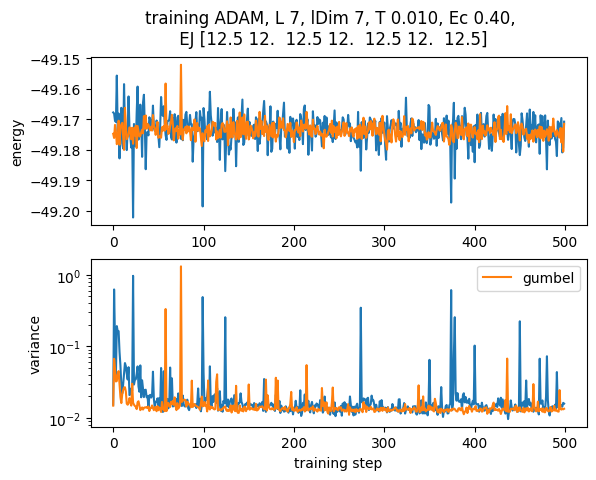

In [29]:
fig,ax = plt.subplots(2)
ax[0].plot(resTrainingADAM[:,0])
ax[1].semilogy(resTrainingADAM[:,1])
ax[0].plot(resTrainingADAM_gumbel[:,0])
ax[1].semilogy(resTrainingADAM_gumbel[:,1],label="gumbel")
ax[1].legend()
ax[0].set_ylabel("energy")
ax[1].set_ylabel("variance")
ax[1].set_xlabel("training step")
fig.suptitle(f"training ADAM, L {L}, lDim {lDim}, T {T:.3f}, Ec {E_c:.2f},\n EJ {E_J}")

[]

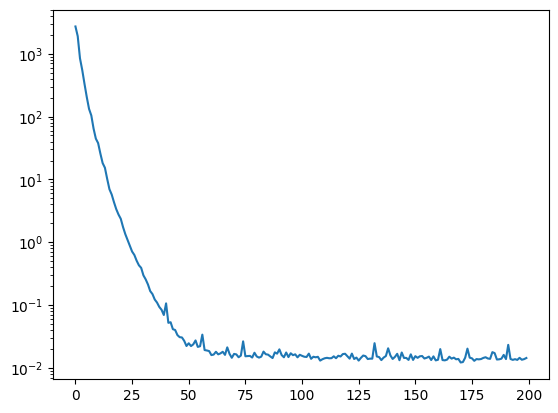

In [30]:
#plt.plot(resTraining[:,1],'x')
plt.plot(resTraining_gumbel[:,1])
#plt.ylim(-10,10)
plt.semilogy()

In [31]:
energyExact = energyED
plt.plot(resTraining[:,1],np.abs(resTraining[:,0]-(energyExact)),'x',label="simple AR")
plt.plot(resTraining_gumbel[:,1],np.abs(resTraining_gumbel[:,0]-(energyExact)),'-+',label="gumbel AR")
plt.loglog()
plt.xlabel("variance")
plt.ylabel("error")
plt.title(f"samples {numS}, {N} particles, {L} sites, {J:.2f} hopping, {U:.2f} interaction")
plt.legend()

NameError: name 'energyED' is not defined

In [ ]:
psi_state_gumbel= np.exp(psi_RWKV_gumbel(jnp.array([fock.fockArray]))*2)
psi_state= np.exp(psi_RWKV(jnp.array([fock.fockArray]))*2)

In [ ]:
plt.semilogy(stateED[:,0]**2,linewidth=4)
plt.semilogy(psi_state_gumbel[0],)
plt.semilogy(psi_state[0],)

In [ ]:
plt.semilogy(np.abs(stateED[:,0]**2-psi_state_gumbel[0]),label="gumbel")
plt.semilogy(np.abs(stateED[:,0]**2-psi_state[0]),label="simple AR")
plt.legend()
error_props = np.sum(np.abs(stateED[:,0]**2-psi_state[0]))
error_props_gumbel = np.sum(np.abs(stateED[:,0]**2-psi_state_gumbel[0]))
print(error_props,error_props_gumbel)

In [ ]:
sorted_indicesED = np.argsort(stateED[:,0]**2,)[::-1]
plt.semilogy(psi_state[0,sorted_indicesED],label="normal")
plt.semilogy(psi_state_gumbel[0,sorted_indicesED],label="gumbel")

plt.semilogy(stateED[sorted_indicesED,0]**2,label="eD")
plt.xlim(-1,1000)
plt.ylim(1e-12,11,)
plt.legend()

In [ ]:
fock.fockArray[sorted_indicesED[:10]]

In [ ]:
sampler_gumbel.sample(numSamples=2**4)

In [ ]:
sampler.sample(numSamples=2**5)

In [ ]:
psi_RWKV(jnp.array([[[1, 0, 2, 1, 1, 1, 1, 1],[1, 1, 2, 0, 1, 1, 1, 1]]]))

In [ ]:
psi_RWKV_gumbel(jnp.array([[[1, 0, 2, 1, 1, 1, 1, 1],[1, 1, 2, 0, 1, 1, 1, 1]]]))

In [ ]:
keys = jrnd.split(jrnd.PRNGKey(12),12)
numSamples= 12
key0=jrnd.split(keys[0],numSamples)#(numSamples,1))

In [ ]:
key0.shape